<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Yield-data" data-toc-modified-id="Yield-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Yield data</a></span></li><li><span><a href="#Input-time-series" data-toc-modified-id="Input-time-series-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Input time-series</a></span></li><li><span><a href="#Regression" data-toc-modified-id="Regression-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Regression</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Results</a></span></li><li><span><a href="#Climatic-data" data-toc-modified-id="Climatic-data-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Climatic data</a></span></li><li><span><a href="#Additional-information" data-toc-modified-id="Additional-information-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Additional information</a></span><ul class="toc-item"><li><span><a href="#Yield-data" data-toc-modified-id="Yield-data-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Yield data</a></span></li></ul></li></ul></div>

In [2]:
import ee
import datetime
import pandas as pd
from IPython.display import Image
from pylab import *
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import shapely
import json
from shapely.geometry import Polygon, MultiPolygon, Point
import geojson
import pickle
import warnings
warnings.filterwarnings('ignore')
import iisignature
from addtime import AddTime, LeadLag
from importlib import reload
import experiments
from experiments import * 
import GP_models.GP_sig_precomputed as GP_sig
from IPython.display import Image
import signature_features
from signature_features import *
import esig.tosig as esig

ModuleNotFoundError: No module named 'addtime'

# Introduction

**Problem**

We try to predict the wheat yield at the level of regions in France with remote sensing data. For region $i$, the input data correspond to $N_i$ time series $x^i_1,\ldots,x^{i}_{N_i}$ measured over $N_i$ locations within the region. The output is the yield $y^i$ for the region. 

**Model**

We construct input output pairs $(\mu^i,y^i)$ with
$\mu^i=(S(x^i_1)+\ldots+S(x^{i}_{N_i}))/N_i$. The regression model is $y^i=f(\mu^i)+\epsilon^i,~\epsilon^i\sim\mathcal{N}(0,\sigma^2)$, where $f$ is learned with Gaussian process regression. The kernel of the GP is an RBF kernel.

**Data**

The yield data comes from the Eurostat database (https://ec.europa.eu/eurostat), and for the remote sensing data we use a dataset published in https://www.sciencedirect.com/science/article/pii/S2352340919311655. 

The remote sensing dataset contains georeferenced univariate time series associated with $21\,129$ fields from $2006$ to $2017$. The variables consist in two vegetation indices (ndvi and evi) and two spectral bands (red and near infrared). The type of crop cultivated on each field is reported for each year. We consider only wheat crops, as these are the most common. 

The yield for wheat crops is available at the level of NUTS2 regions.

# Yield data

The NUTS2 regions have been renamed in 2013, hence we need to take this into account when reading the data for years before and after 2013

In [5]:
dico_nuts_2016 = {'FRE1':'FR30','FRE2':'FR22','FR10':'FR10','FRF2':'FR21','FRF3':'FR41','FRF1':'FR42','FRC2':'FR43','FRK2':'FR71','FRL0':'FR82','FRJ1':'FR81','FRJ2':'FR62','FRI1':'FR61','FRI3':'FR53','FRI2':'FR63','FRK1':'FR72','FRH0':'FR52','FRG0':'FR51','FRB0':'FR24','FRD1':'FR25','FRD2':'FR23','FRC1':'FR26','FRM0':'FR83'}
dico_nuts_2013 = {}
for key in dico_nuts_2016.keys():
    dico_nuts_2013[dico_nuts_2016[key]]=key

Load and subset the yield data from eurostat

In [6]:
dy = pd.read_csv('/Users/maudlemercier/Desktop/Learning_Streams_Sets/apro_cpshr.tsv',delimiter='\t')

# parse the first column
dy['crop']=dy[dy.columns[0]].apply(lambda x: x.split(',')[0])
dy['strucpro']=dy[dy.columns[0]].apply(lambda x: x.split(',')[1])
dy['geotime']=dy[dy.columns[0]].apply(lambda x: x.split(',')[2])
dy = dy.drop(columns=[dy.columns[0]])
cols = dy.columns.tolist()
cols = cols[-3:] + cols[:-3]
dy = dy[cols]

# the years have a spurious space
dico_col = {}
for year in dy.columns[3:]:
    dico_col[year]=year[:-1]
    
dy = dy.rename(columns=dico_col)

# get only the data relative to France
french_data = dy['geotime'].isin(list(dico_nuts_2013.keys())+list(dico_nuts_2016.keys()))
dy = dy[french_data]


# get only the data for wheat 
wheat = ['C1110']   
wheat_data = dy['crop'].isin(wheat)
dy = dy[wheat_data]
dy.strucpro.unique()

# get the data to compute the yield
yield_ = dy.strucpro.isin(['AR','PR_HU_EU'])
dy = dy[yield_]

Load the polygons for the NUTS2 regions `polygons`

In [7]:
polygons = gpd.read_file('/Users/maudlemercier/Desktop/Learning_Streams_Sets/ref-nuts-2016-20m.shp/NUTS_RG_20M_2016_4326_LEVL_2.shp/NUTS_RG_20M_2016_4326_LEVL_2.shp')
polygons = polygons[polygons.CNTR_CODE=='FR']
polygons = polygons[polygons.FID.isin(dico_nuts_2016.keys())]

Merge the yield dataframe with the polygons `data` 

In [9]:
list_year = []

years = [str(e) for e in np.arange(2006,2018) if e!=2014]

for year in years:
    
    g_df = gpd.GeoDataFrame(pd.DataFrame(polygons[['geometry','NUTS_ID']], columns = ['geometry','NUTS_ID']), geometry = 'geometry')
    g_df["AR"] = np.nan
    g_df["PR_HU_EU"] = np.nan
    g_df["PR_div_AR"] = np.nan
    g_df["year"] = year
    g_df["colors"]=sns.hls_palette(len(list(dico_nuts_2016.keys())))
    df_year = dy[['strucpro','geotime',year]]
    
    for nut in polygons.NUTS_ID.values:
        
        df_nut = df_year[df_year.geotime==dico_nuts_2016[nut]]
        
        if ':' in df_nut[year].values[0]: # if the NUTS regions have been renamed
            df_nut = df_year[df_year.geotime==nut]
        
        if not ':' in df_nut[year].values[0]: # if data is available for the year
            g_df.loc[g_df.NUTS_ID==nut,"AR"] = float(df_nut[df_nut.strucpro=='AR'][[year]].values[0][0])
            g_df.loc[g_df.NUTS_ID==nut,"PR_HU_EU"] = float(df_nut[df_nut.strucpro=='PR_HU_EU'][[year]].values[0][0])
            g_df.loc[g_df.NUTS_ID==nut,"PR_div_AR"] = float(df_nut[df_nut.strucpro=='PR_HU_EU'][[year]].values[0][0])/float(df_nut[df_nut.strucpro=='AR'][[year]].values[0][0])

    list_year.append(g_df)

data = pd.concat(list_year)
data.crs = {'init': 'epsg:4326'}
data=data.to_crs("EPSG:3395")

Visualization

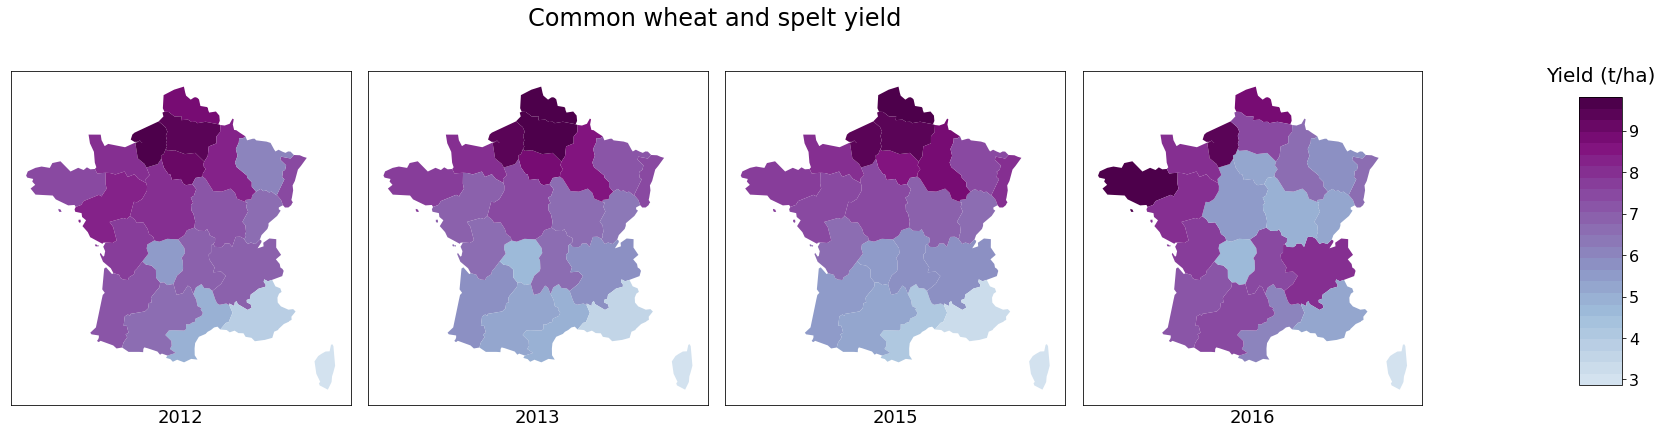

In [7]:
fig,ax = plt.subplots(1,4,figsize=(20,5))
axs = ax.ravel()

cmap1 = matplotlib.cm.BuPu(np.linspace(0,1,30))
cmap2 = matplotlib.colors.ListedColormap(cmap1[5:,:-1])

vmin = data.PR_div_AR.values.min()
vmax = data.PR_div_AR.values.max()

for i,year in enumerate(['2012','2013','2015','2016']):
    g_plot = data[data.year==year].plot(column=data[data.year==year].PR_div_AR,ax=axs[i],cmap=cmap2)
    axs[i].set_xlabel(str(year),fontsize=18)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    #axs[i].axis('off')

fig = g_plot.get_figure()
cax = fig.add_axes([1.1, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
cax.tick_params(labelsize=16)

cax.set_title('Yield (t/ha)', rotation=0,fontsize=20,pad=16)

fig.suptitle('Common wheat and spelt yield',fontsize=24,y=1.15)
fig.tight_layout()
plt.show()



Variability of the yield per region

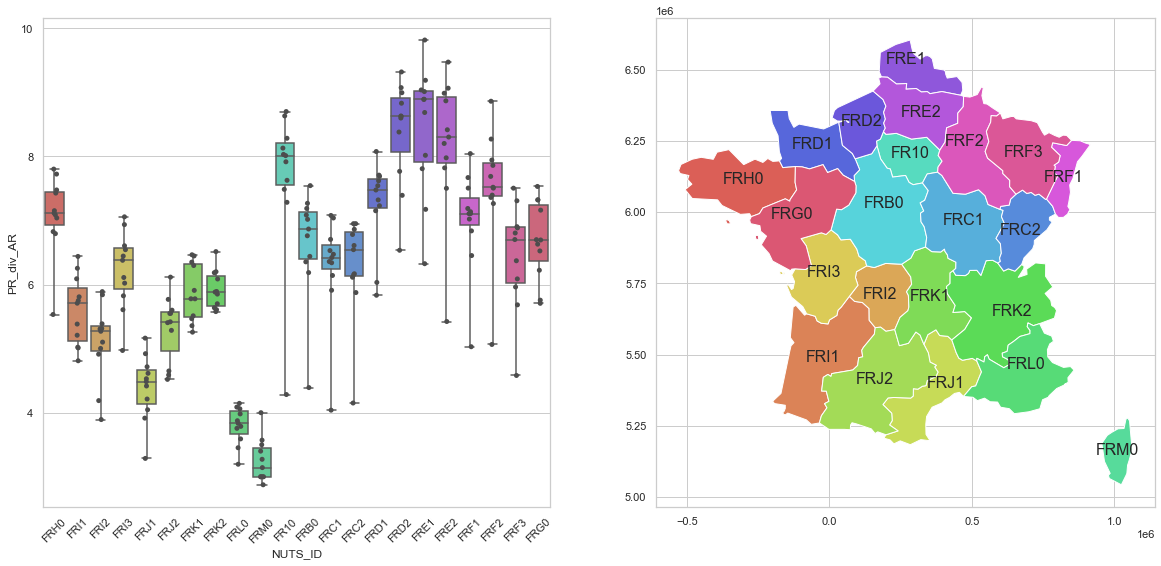

In [8]:
sns.set(style="whitegrid")
fig,ax = plt.subplots(1,2,figsize=(20,9))
axs = ax.ravel()
ax = sns.boxplot(x="NUTS_ID", y="PR_div_AR", data=data, whis=np.inf,palette=sns.hls_palette(len(list(dico_nuts_2016.keys()))),ax=ax[0])
ax = sns.stripplot(x="NUTS_ID", y="PR_div_AR", data=data, color=".3",ax=axs[0])
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

sns.set(font_scale=3)
g_plot = data[data.year==year].plot(ax=axs[1],color=data[data.year==year].colors)

df = data[data.year==year]
df['coords'] = df['geometry'].apply(lambda x: x.representative_point().coords[:])
df['coords'] = [coords[0] for coords in df['coords']]
for idx, row in df.iterrows():
    plt.annotate(s=row['NUTS_ID'], xy=row['coords'],
                 horizontalalignment='center',fontsize=16)

plt.show()

# Input time-series

In [9]:
crops = pd.read_csv('/Users/maudlemercier/Desktop/Learning_Streams_Sets/ScienceDirect_files_08May2020_11-55-06.876/time_series_crop.csv',delimiter=';')

Add a column to the dataframe which tells within which NUTS2 region the field is

In [10]:
def find_poly(x):
    point = Point(x[1],x[2])
    for i,poly in enumerate(polygons.geometry):
        if point.within(poly):
            return polygons.NUTS_ID.values[i]
def create_point(x):
    return(Point(x[1],x[2]))
    
crops['NUTS_ID'] = crops.apply(find_poly,axis=1)
crops['Point'] = crops.apply(create_point,axis=1)

How many wheat fields

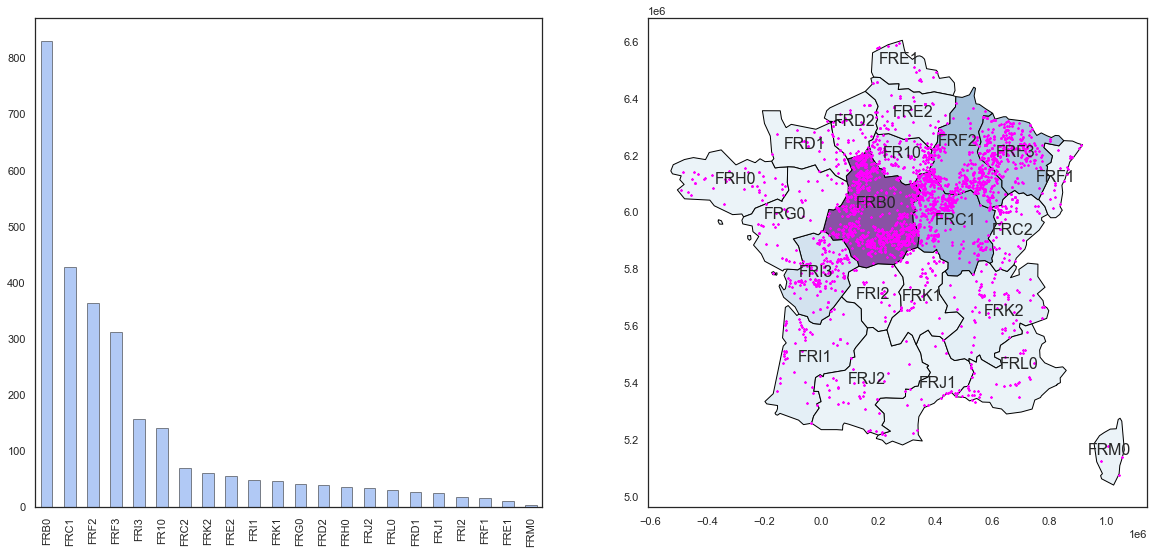

In [11]:
sns.set(style='white',font_scale=1)
fig,ax = plt.subplots(1,2,figsize=(20,9))
axs = ax.ravel()
year = '2006'
wheat_within_year = crops[['crop_'+year,'NUTS_ID','Point']]
wheat_within_year = wheat_within_year[wheat_within_year.crop_2006=='Wheat']

df = data[data.year==year][['geometry','NUTS_ID','colors']]

df['counts']=np.nan

dico_colors = {}
dico_count = {}

cmap1 = matplotlib.cm.BuPu(np.linspace(0,0.7,21))
cmap2 = matplotlib.colors.ListedColormap(cmap1[2:,:-1])

for i,nut in  enumerate(wheat_within_year.NUTS_ID.value_counts().index):
    try:
        df.loc[df.NUTS_ID==nut,"counts"]=wheat_within_year.NUTS_ID.value_counts().iloc[i]
    except:
        pass

wheat_within_year.NUTS_ID.value_counts().plot(kind='bar',ax=axs[0],color='cornflowerblue',ec='k',alpha=0.5)

g_plot = df.plot(column=df.counts,ax=ax[1],cmap=cmap2,edgecolor="black")
wheat_within_year = crops[['crop_'+str(year),'NUTS_ID','Point']]
wheat_within_year = wheat_within_year[wheat_within_year['crop_'+str(year)]=='Wheat']

crops_points = gpd.GeoDataFrame(pd.DataFrame(wheat_within_year[['Point']], columns = ['Point']), geometry = 'Point')
crops_points.crs = {'init': 'epsg:4326'}
crops_points=crops_points.to_crs("EPSG:3395")
crops_points.plot(ax=axs[1],marker='*', color='magenta', markersize=4)
#axs[1].axis('off')
df = data[data.year==year]
df['coords'] = df['geometry'].apply(lambda x: x.representative_point().coords[:])
df['coords'] = [coords[0] for coords in df['coords']]
for idx, row in df.iterrows():
    plt.annotate(s=row['NUTS_ID'], xy=row['coords'],
                 horizontalalignment='center',fontsize=16)
# plt.show()

In [12]:
ndvi = pd.read_csv('/Users/maudlemercier/Desktop/Learning_Streams_Sets/ScienceDirect_files_08May2020_11-55-06.876/time_series_NDVI.csv')
ndvi = ndvi.join(crops['NUTS_ID'])
evi = pd.read_csv('/Users/maudlemercier/Desktop/Learning_Streams_Sets/ScienceDirect_files_08May2020_11-55-06.876/time_series_EVI.csv')
evi = evi.join(crops['NUTS_ID'])
red = pd.read_csv('/Users/maudlemercier/Desktop/Learning_Streams_Sets/ScienceDirect_files_08May2020_11-55-06.876/time_series_red.csv')
red = red.join(crops['NUTS_ID'])
nir = pd.read_csv('/Users/maudlemercier/Desktop/Learning_Streams_Sets/ScienceDirect_files_08May2020_11-55-06.876/time_series_NIR.csv')
nir = nir.join(crops['NUTS_ID'])

# Regression

Create the input time series. Take the signature on the fly. But save the time series such that we can compare with the RBF-RBF baseline

In [27]:
# signature spec
level_sig = 3
add_time_tf = AddTime()
lead_lag_tf = LeadLag([1,2])
sig_level1 = 4
sig_level2 = 2

# to store the input/output pairs
expected_sigs = [] 
labels = {}
input_list = []

for year in years:
    print('year: ', year)
    prev_year = str(int(year)-1)
    # get the ndvi time series for all wheat fields in year
    wheat_within_year = crops[['crop_'+str(year),'NUTS_ID','Point','Lat','Long']]
    wheat_within_year = wheat_within_year[wheat_within_year['crop_'+str(year)].isin(['Wheat'])] 
    
    ndvi_subset_fields = ndvi[ndvi.index.isin(wheat_within_year.index)]
    nir_subset_fields = nir[nir.index.isin(wheat_within_year.index)]
    red_subset_fields = red[red.index.isin(wheat_within_year.index)]

#     timestamps =[e for e in ndvi_subset_fields.columns.values if e[5:9]==prev_year][-8:]+[e for e in ndvi_subset_fields.columns.values if e[5:9]==year][:-10]+['NUTS_ID']
#     timestamps_nir = [e for e in nir_subset_fields.columns.values if e[4:8]==prev_year][-8:]+[e for e in nir_subset_fields.columns.values if e[4:8]==year][:-10]+['NUTS_ID']
#     timestamps_red = [e for e in red_subset_fields.columns.values if e[4:8]==prev_year][-8:]+[e for e in red_subset_fields.columns.values if e[4:8]==year][:-10]+['NUTS_ID']

    timestamps =[e for e in ndvi_subset_fields.columns.values if e[5:9]==year][:-10]+['NUTS_ID']
    timestamps_nir = [e for e in nir_subset_fields.columns.values if e[4:8]==year][:-10]+['NUTS_ID']
    timestamps_red = [e for e in red_subset_fields.columns.values if e[4:8]==year][:-10]+['NUTS_ID']

    
    ndvi_subset_fields_year = ndvi_subset_fields.T[ndvi_subset_fields.columns.isin(timestamps)].T
    ndvi_subset_fields_year.dropna(inplace=True)
    nir_subset_fields_year = nir_subset_fields.T[nir_subset_fields.columns.isin(timestamps_nir)].T
    nir_subset_fields_year = nir_subset_fields_year[nir_subset_fields_year.index.isin(ndvi_subset_fields_year.index)]
    red_subset_fields_year = red_subset_fields.T[red_subset_fields.columns.isin(timestamps_red)].T
    red_subset_fields_year = red_subset_fields_year[red_subset_fields_year.index.isin(ndvi_subset_fields_year.index)]
 
    for nut in ndvi_subset_fields_year.NUTS_ID.unique():

        lat = np.mean(wheat_within_year[wheat_within_year.index.isin(ndvi_subset_fields_year[ndvi_subset_fields_year.NUTS_ID==nut].index)][['Lat']].values)
        lon = np.mean(wheat_within_year[wheat_within_year.index.isin(ndvi_subset_fields_year[ndvi_subset_fields_year.NUTS_ID==nut].index)][['Long']].values)
        ndvi_nut = ndvi_subset_fields_year[ndvi_subset_fields_year.NUTS_ID==nut].iloc[:,:-1].to_numpy(dtype ='float32')
        nir_nut = nir_subset_fields_year[nir_subset_fields_year.NUTS_ID==nut].iloc[:,:-1].to_numpy(dtype ='float32')
        red_nut = red_subset_fields_year[red_subset_fields_year.NUTS_ID==nut].iloc[:,:-1].to_numpy(dtype ='float32')
       
        if ndvi_nut.shape[0]>0:

            vi = np.concatenate((nir_nut[:,:,None],red_nut[:,:,None]),axis=2)
            nb = min(30,ndvi_nut.shape[0])         # if we fix the maximum number of items
            #nb = ndvi_nut.shape[0]       
            a = vi[:nb,:,:] 
            input_list.append(a)
            #a = np.mean(vi[:nb,:,:],axis=0)                 # to compare with taking the averaged time series
            a = add_time_tf.fit_transform(a)     
            # embedding the 2-dimensional time series into a 4-dimensional path (adding time and lag)
            #a = add_time_tf.fit_transform(vi[:nb,:,:])       
            a = np.array(a)  # a is of shape (N_fields,T,2)
            
            a = lead_lag_tf.fit_transform(a)
            a = np.array(a)
            
#             expected_pathwise_sig = signature_features.scaled_pathwise_expected_iisignature([a],sig_level1)
#             features = expected_pathwise_sig[0]
#             signatures = iisignature.sig(features,sig_level2)
#             expected_sigs.append(signatures)
            
            expected_sig = np.mean(iisignature.sig(a,level_sig),axis=0)
            expected_sig = np.insert(expected_sig,0,lat-50)
            expected_sig = np.insert(expected_sig,0,lon)
            expected_sigs.append(expected_sig)
            
            label = data[data.year==year]
            label = label[label.NUTS_ID==nut].PR_div_AR.values[0]
            labels[(year,nut)]=label

# save the paths for comparison with baseline    
pickle.dump(input_list,open('input_list_RBF.obj','wb')) 
pickle.dump(np.array([labels[key] for key in labels.keys()])[:,None],open('output_RBF.obj','wb')) 

year:  2006
year:  2007
year:  2008
year:  2009
year:  2010
year:  2011
year:  2012
year:  2013
year:  2015
year:  2016
year:  2017


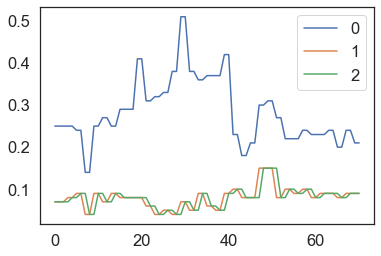

In [324]:
plt.plot(input_list[0][0,:,0],label='0')
plt.plot(input_list[0][0,:,1],label='1')
plt.plot(input_list[0][0,:,2],label='2')
plt.legend()
plt.show()

Train/Test split

In [28]:
# remove a year

# year_out = np.sort(np.random.choice(np.arange(11),1,replace=False)) #np.arange(220)
# year_out = 1
# train_indices = []
# for i in range(242):
#     if not i in np.arange(year_out*22,(year_out+1)*22):
#         train_indices.append(i)
# train_indices = np.array(train_indices)
# test_indices = [ind for ind in np.arange(len(labels)) if not ind in train_indices]#np.arange(50,len(labels))#np.arange(220,len(labels))#

# stratify split 
# y = np.array([labels[key] for key in labels.keys()])
# bins = np.linspace(-0.1 + min(y), max(y) + 0.1, 10)
# y_binned = np.digitize(y, bins)

# train_indices, test_indices, _, _ = train_test_split(np.arange(len(y_binned)), np.array(y_binned), shuffle=True, test_size=1. /11,
#                                      stratify=y_binned,random_state=0)


train_indices = np.arange(220)
test_indices = np.arange(220,242)

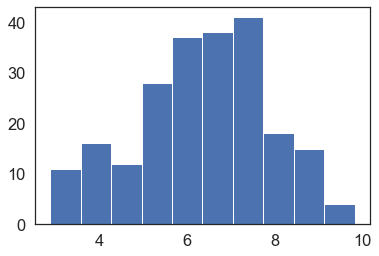

In [355]:
plt.hist(y[train_indices])
plt.show()

 Precompute the Gram Matrix with elements $\langle \mathbb{E}[S(x^i)],\mathbb{E}[S(x^j)]\rangle$

In [29]:
# We do not take into account the centroid of the region, to assess the performances on the remote sensing data only
features = np.array(expected_sigs)[:,2:]  

# Scale the (expected) signature features
scaler = StandardScaler()
to_fit = [features[i] for i in train_indices]
scaler.fit(to_fit)
features = scaler.transform(features)

# feat_select = [3,9,10,30]
# features = features[:,feat_select]
# print(features.shape)

# # Precompute the Gram matrix
K_precomputed = experiments.precompute_K(features)

Fit the model

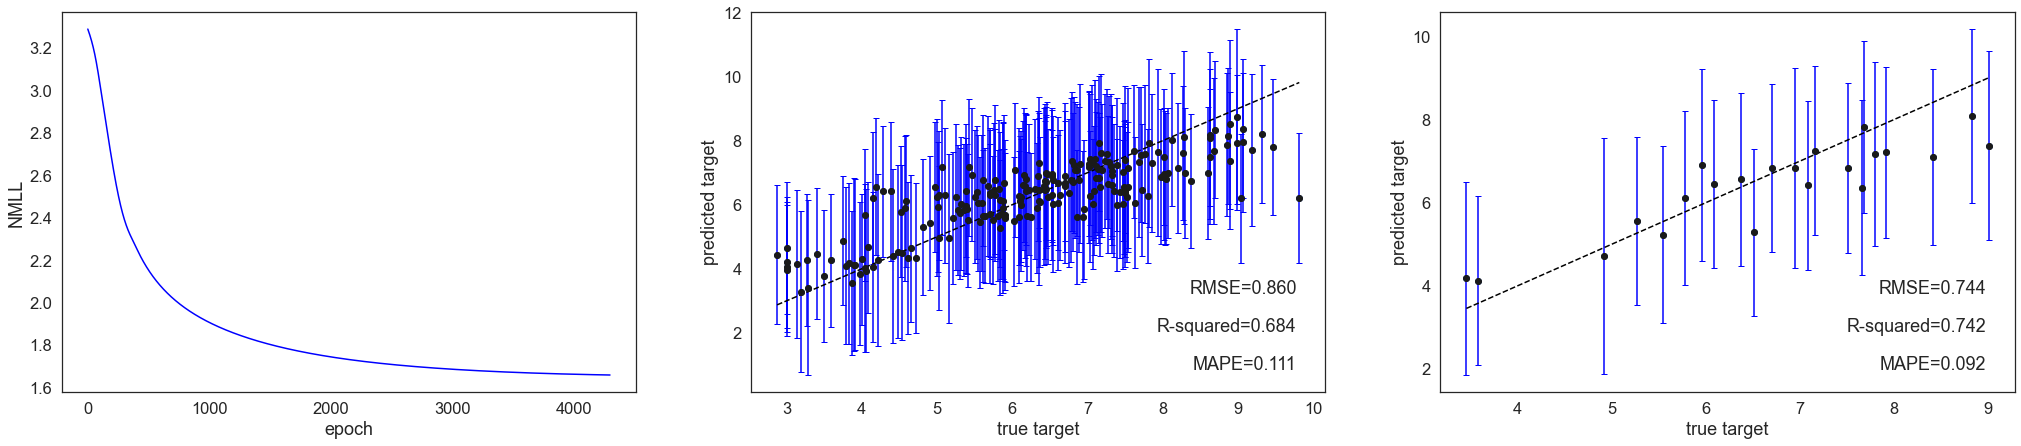

In [31]:
reload(experiments)
reload(GP_sig)
import GP_models.GP_sig_ARD_full as GP_sig_ARD_full
reload(GP_sig_ARD_full)
a,b,c,d = experiments.experiment_precomputed(K_precomputed, np.array([labels[key] for key in labels.keys()])[:,None],train_indices,test_indices,param_init=[0,50,0],RBF=True,plot=True)
#a,b,c,d,l = experiments.experiment_ARD(features,np.array([labels[key] for key in labels.keys()])[:,None],5,level_sig,train_indices,test_indices,param_init=[0,0,0],RBF=True,plot=True,full=True)

39
39


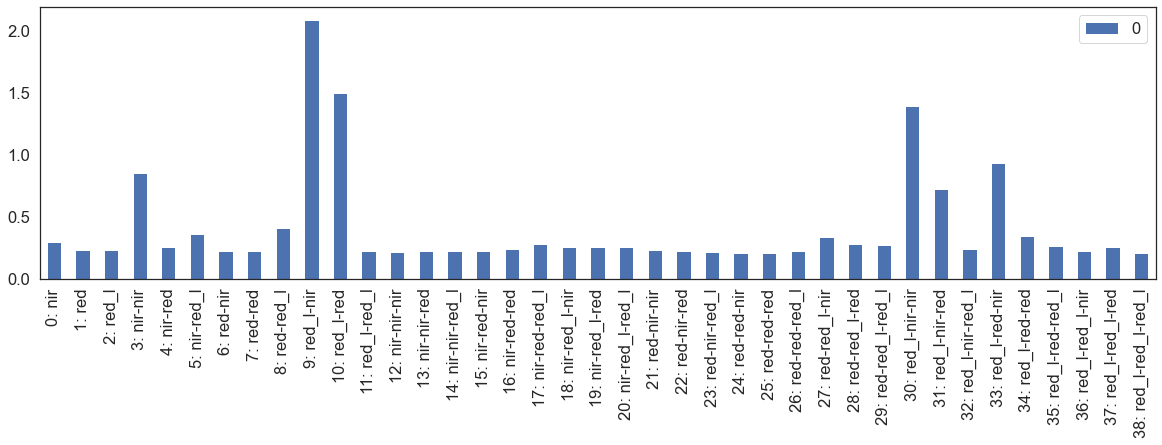

In [343]:
def get_sig_keys(ndims, sig_level):
    keys = esig.sigkeys(ndims,sig_level).split("(")
    sig_keys = []

    for i in range(2,len(keys)-1):
        sig_keys.append(np.array(keys[i][:-2].split(',')))
    sig_keys.append(np.array(keys[len(keys)-1][:-1].split(',')))
    return sig_keys
keys = get_sig_keys(3, level_sig)
#dico = {'1':'time', '2':'nir','3':'red','4':'nir_l','5':'red_l'}#,'3':'red','4':'nir-lag'}
dico = {'1':'nir','2':'red','3':'red_l'}#,'4':'red_l'}
features_names = []
for i in range(features.shape[1]):
    separator = '-'
    name = separator.join([dico[e] for e in keys[i]])
    features_names.append(str(i)+': '+name)
print(len(features_names))
print(features.shape[1])
fig, ax = plt.subplots(1,figsize=(20,5))
lengthscales = pd.DataFrame([1./e for e in l][:50])
lengthscales.index = features_names[:50]
lengthscales.plot(kind='bar',ax=ax,rot=90)
plt.show()



# Results

In this experiment, instead of using a vegetation indice as input, we use the two spectral bands, and let the regressor find how to combine them. Preliminary experiments (with the Signature method) show that using the two spectral bands *nir* and *red* outperforms the *ndvi*, and yields similar results than the *evi*. 

**Lin-RBF 30 items maximum (executed on GPU)**

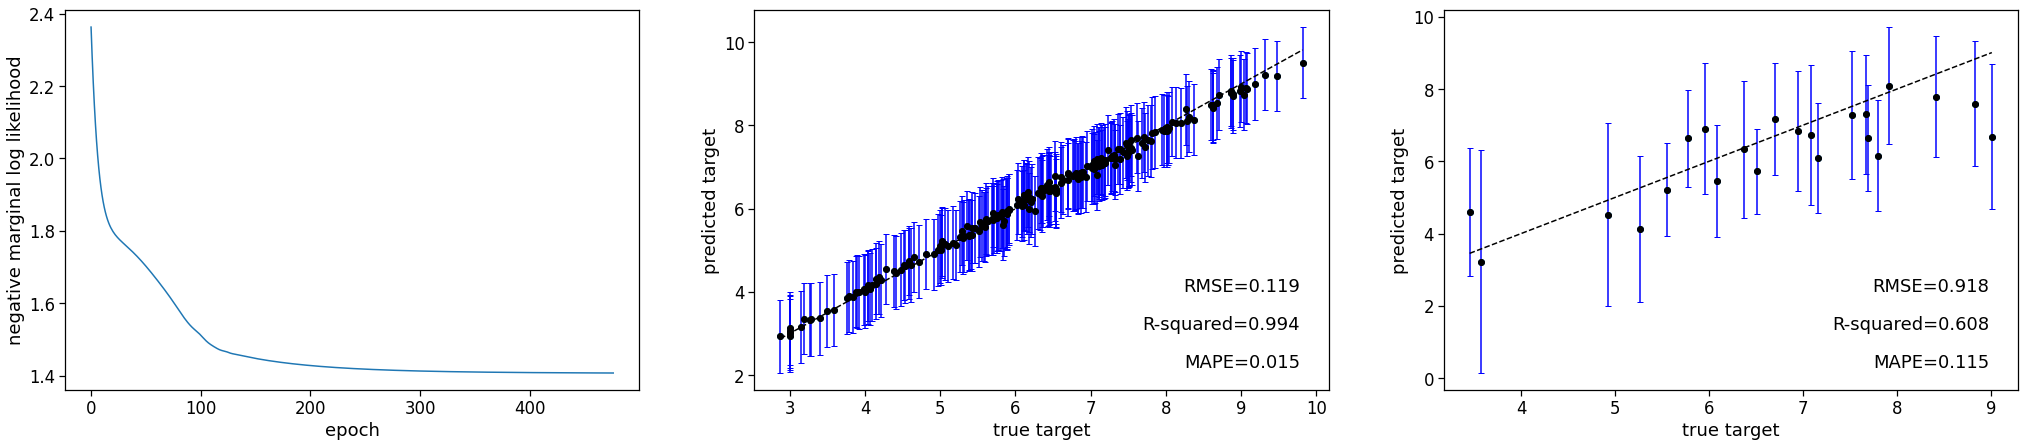

In [27]:
Image(filename="results_french_NUTS/Lin_RBF_30items.png")

**RBF-RBF 30 items maximum (executed on GPU)**

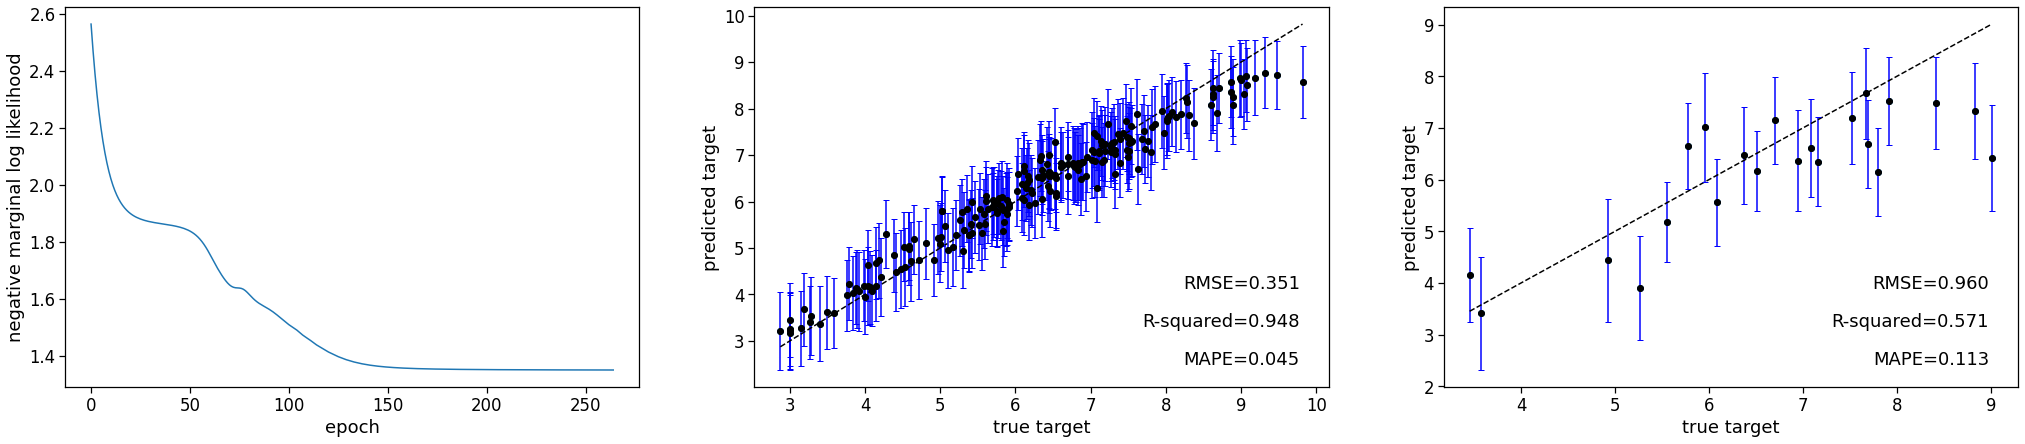

In [28]:
Image(filename="results_french_NUTS/RBF_RBF_30items.png")

**RBF-Sig 30 items maximum (executed on this notebook)**

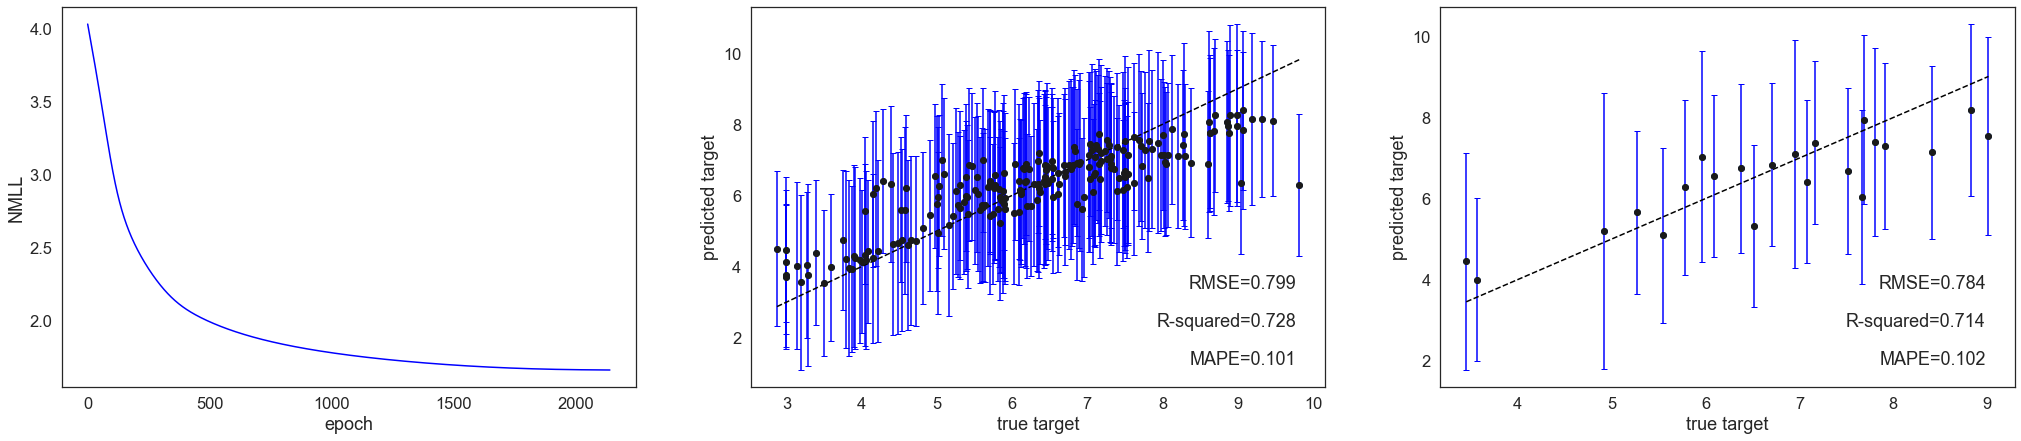

In [30]:
Image(filename="results_french_NUTS/RBF_Sig_30items_noARD.png")

**RBF-Sig all items (executed on this notebook)**

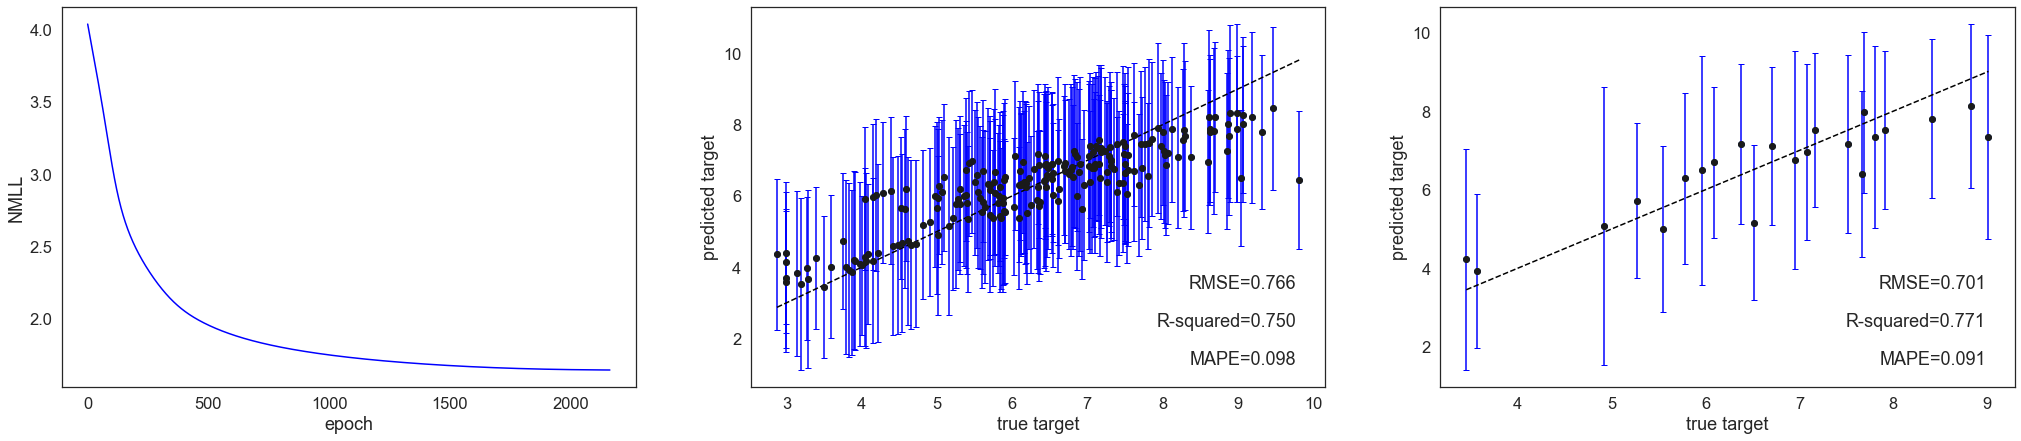

In [31]:
Image(filename="results_french_NUTS/RBF_Sig_allitems_noARD.png")

# Climatic data

The 3-hourly temperature/humidity/rainfall have been collected with the Google Earth Engine Python API for each pixel in each NUT2 region.

In [44]:
# df = pickle.load(open('data_clim_France/FRH0_2008_2011.obj','rb'))
ndvi

,ID,NDVI_2005_305,NDVI_2005_313,NDVI_2005_321,NDVI_2005_329,NDVI_2005_337,NDVI_2005_345,NDVI_2005_353,NDVI_2005_361,NDVI_2006_001,...,NDVI_2017_297,NDVI_2017_305,NDVI_2017_313,NDVI_2017_321,NDVI_2017_329,NDVI_2017_337,NDVI_2017_345,NDVI_2017_353,NDVI_2017_361,NUTS_ID
0,1,0.66,0.60,0.61,0.07,0.09,0.09,0.04,0.08,0.04,...,0.61,0.57,0.47,0.11,0.11,0.06,0.08,0.09,0.12,FRK2
1,2,0.65,0.63,0.61,0.04,0.07,0.04,0.01,0.02,0.00,...,0.63,0.59,0.54,0.52,0.10,0.01,-0.02,0.06,0.07,FRK2
2,3,0.49,0.52,0.37,0.48,0.45,0.43,0.41,0.43,0.24,...,0.73,0.61,0.62,0.79,0.65,0.84,0.67,0.70,0.64,FRK2
3,4,0.49,0.52,0.37,0.48,0.45,0.43,0.41,0.43,0.24,...,0.73,0.61,0.62,0.79,0.65,0.84,0.67,0.70,0.64,FRK2
4,5,0.65,0.65,0.63,0.02,0.02,0.01,0.00,0.03,0.01,...,0.63,0.59,0.57,0.55,0.02,-0.01,-0.03,0.04,0.07,FRK2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21124,21125,0.17,0.44,0.24,0.25,0.13,0.38,0.39,0.29,0.39,...,0.30,0.63,0.59,0.30,0.44,0.64,0.52,0.52,0.45,FR10
21125,21126,0.35,0.35,0.53,0.40,0.40,0.45,0.44,0.42,0.44,...,0.25,0.25,0.25,0.25,0.28,0.39,0.27,0.51,0.33,FR10
21126,21127,0.58,0.45,0.51,0.43,0.58,0.58,0.49,0.48,0.49,...,0.54,0.63,0.62,0.64,0.49,0.65,0.62,0.81,0.61,FR10
21127,21128,0.46,0.42,0.43,0.34,0.41,0.51,0.37,0.38,0.37,...,0.60,0.69,0.68,0.67,0.56,0.72,0.62,0.76,0.58,FR10


# Additional information

## Yield data

**documentation:** https://ec.europa.eu/eurostat/cache/metadata/Annexes/apro_cp_esms_an1.pdf

**wheat codes:**
- C1100 Wheat and spelt  (no AR) 
- C1110 Common wheat and spelt = C1111 + C1112 
- C1111 Common winter wheat and spelt
- C1112 Common spring wheat and spelt (no AR)
- C1120 Durum wheat

**vocabulary:**
http://dd.eionet.europa.eu/vocabulary/eurostat/strucpro/view 

**yield:** we use PR_HU_EU/AR to compute the yield at the level of NUTS 2 regions

**spatial resolution:** the data is at level NUTS 2 (2013) https://ec.europa.eu/eurostat/documents/345175/7451602/2016-NUTS-2-map-FR.pdf
https://ec.europa.eu/eurostat/web/nuts/nuts-maps

**missing data:** year 2014 has no data






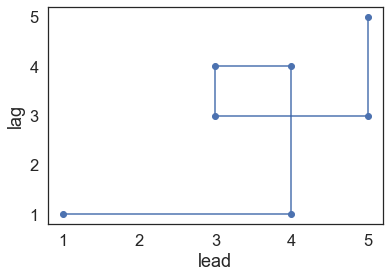

[['time', 3.0], ['lead', 4.0], ['lag', 4.0], ['time-time', 4.5], ['time-lead', 5.0], ['time-lag', 7.0], ['lead-time', 7.0], ['lead-lead', 8.0], ['lead-lag', 15.0], ['lag-time', 5.0], ['lag-lead', 1.0], ['lag-lag', 8.0]]


In [17]:
path = np.array([[0,1],[1,4],[2,3],[3,5]])
lead_lag_tf = LeadLag([1])
a = lead_lag_tf.fit_transform([path])[0]
a = np.array(a)
#plt.plot(path[:,1])
plt.plot(a[:,1],a[:,2])
plt.scatter(a[:,1],a[:,2])
plt.xlabel('lead')
plt.ylabel('lag')

plt.show()
sig = iisignature.sig(a,2)

def get_sig_keys(ndims, sig_level):
    keys = esig.sigkeys(ndims,sig_level).split("(")
    sig_keys = []
    for i in range(2,len(keys)-1):
        sig_keys.append(np.array(keys[i][:-2].split(',')))
    sig_keys.append(np.array(keys[len(keys)-1][:-1].split(',')))
    return sig_keys
keys = get_sig_keys(3, 2)
dico = {'1':'time', '2':'lead','3':'lag'}#,'3':'red','4':'nir-lag'}
features_names = []
for i in range(len(sig)):
    separator = '-'
    name = separator.join([dico[e] for e in keys[i]])
    features_names.append(name)
print([[features_names[i],sig[i]] for i in range(len(sig))])

In [23]:
# reload(experiments)
# train_index = 220
# y = np.array([labels[key] for key in labels.keys()])[:,None]
# # but we stack dimensions of the paths
# input_ = [np.concatenate([region[:,:,k] for k in range(2)],axis=1) for region in input_list]

# # Train and predict
# a,b,c,d = experiments.naive_experiment_arbitrary(input_, y, train_index, ARD=False,RBF_top=True, param_init=[10, 0, 0,10], plot=True,
#                      device=torch.device("cpu"))

In [32]:
ndvi

,ID,NDVI_2005_305,NDVI_2005_313,NDVI_2005_321,NDVI_2005_329,NDVI_2005_337,NDVI_2005_345,NDVI_2005_353,NDVI_2005_361,NDVI_2006_001,...,NDVI_2017_297,NDVI_2017_305,NDVI_2017_313,NDVI_2017_321,NDVI_2017_329,NDVI_2017_337,NDVI_2017_345,NDVI_2017_353,NDVI_2017_361,NUTS_ID
0,1,0.66,0.60,0.61,0.07,0.09,0.09,0.04,0.08,0.04,...,0.61,0.57,0.47,0.11,0.11,0.06,0.08,0.09,0.12,FRK2
1,2,0.65,0.63,0.61,0.04,0.07,0.04,0.01,0.02,0.00,...,0.63,0.59,0.54,0.52,0.10,0.01,-0.02,0.06,0.07,FRK2
2,3,0.49,0.52,0.37,0.48,0.45,0.43,0.41,0.43,0.24,...,0.73,0.61,0.62,0.79,0.65,0.84,0.67,0.70,0.64,FRK2
3,4,0.49,0.52,0.37,0.48,0.45,0.43,0.41,0.43,0.24,...,0.73,0.61,0.62,0.79,0.65,0.84,0.67,0.70,0.64,FRK2
4,5,0.65,0.65,0.63,0.02,0.02,0.01,0.00,0.03,0.01,...,0.63,0.59,0.57,0.55,0.02,-0.01,-0.03,0.04,0.07,FRK2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21124,21125,0.17,0.44,0.24,0.25,0.13,0.38,0.39,0.29,0.39,...,0.30,0.63,0.59,0.30,0.44,0.64,0.52,0.52,0.45,FR10
21125,21126,0.35,0.35,0.53,0.40,0.40,0.45,0.44,0.42,0.44,...,0.25,0.25,0.25,0.25,0.28,0.39,0.27,0.51,0.33,FR10
21126,21127,0.58,0.45,0.51,0.43,0.58,0.58,0.49,0.48,0.49,...,0.54,0.63,0.62,0.64,0.49,0.65,0.62,0.81,0.61,FR10
21127,21128,0.46,0.42,0.43,0.34,0.41,0.51,0.37,0.38,0.37,...,0.60,0.69,0.68,0.67,0.56,0.72,0.62,0.76,0.58,FR10
